# Wyznaczanie krzywej ROC

## Przygotowanie  klasyfikatora

In [40]:
import numpy as np

from haar_students_new import haar_features_indexes, haar_features_coordinates
from haar_students_new import unpickle_all
from realboostbins import RealBoostBins

In [41]:
path_data_root = "../data/"
path_clfs_root = "../clfs/"
s = 6
p = 4
hfs_indexes = haar_features_indexes(s, p)
hfs_coords = haar_features_coordinates(hfs_indexes, s, p)
n = len(hfs_indexes)
print("NO. OF HAAR-LIKE FEATURES: " + str(n))
data_description = "n_" + str(n) + "_s_" + str(s) + "_p_" + str(p)
path_data = path_data_root + "fddb_" + data_description + ".pkl" # path for Karl
# path_data = path_data_root + "datafddb_" + data_description + ".pkl" # path for Wojtas

NO. OF HAAR-LIKE FEATURES: 8820


C:\Dev\machine_learning_2\src\haar_students_new.py:112: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(hfs_coords)


## Podział na część uczącą i testującą

In [42]:
X_train, y_train, X_test, y_test = unpickle_all(path_data)
print(f'X_train: {X_train.shape}')
print(f'y_test: {y_test.shape}')
train_index_pos = np.where(y_train == 1)[0]
train_index_neg = np.where(y_train == -1)[0]
print("X_TRAIN: " + str(X_train.shape) + " [POSITIVES: " + str(train_index_pos.size) + "]")
test_index_pos = np.where(y_test == 1)[0]
test_index_neg = np.where(y_test == -1)[0]
print("X_TEST: " + str(X_test.shape) + " [POSITIVES: " + str(test_index_pos.size) + "]")

UNPICKLE...
UNPICKLE DONE. [TIME: 1.7359981536865234 s.]
X_train: (29863, 8820)
y_test: (3269,)
X_TRAIN: (29863, 8820) [POSITIVES: 4213]
X_TEST: (3269, 8820) [POSITIVES: 469]


In [43]:
T = 128  # 128 słabych klasyfikatorów
B = 8  # maximum depth
clf_description = data_description + "_T_" + str(T) + "_B_" + str(B)
path_clf = path_clfs_root + "fddb_real_" + clf_description + ".pkl"
# clf = RealBoostBins(T, B)
# print("LEARNING...")
# t1 = time.time()
# clf.fit(X_train, y_train)
# t2 = time.time()
# print(f"LEARNING DONE IN {t2 - t1} s.")
# pickle_all(path_clf, [clf])
clf = unpickle_all(path_clf)[0]
fi = np.unique(clf.features_).astype("int32")
print(f"SELECTED FEATURES {len(fi)}")

UNPICKLE...
UNPICKLE DONE. [TIME: 0.00099945068359375 s.]
SELECTED FEATURES 125


## Wyznaczanie krzywej ROC

In [44]:
from sklearn import metrics
import matplotlib.pyplot as plt
import pandas as pd

def accuracy_threshold_values(X_test, y_test, clf, log=False):
    y_scores = clf.decision_function(X_test)
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_scores)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.ylim([0.0, 1.05])
    if log:
        plt.xscale('log')
    else:
        plt.xlim([0.0, 1.0])
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--') 
    plt.show()

    print(f'accuracy_threshold_values DONE')
    return fpr, tpr, thresholds

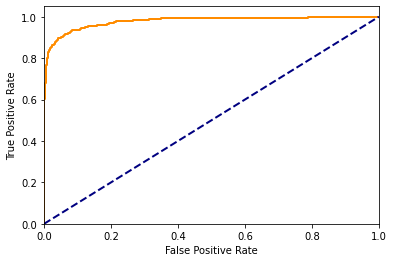

accuracy_threshold_values DONE


In [45]:
fpr, tpr, thresholds = accuracy_threshold_values(X_test, y_test, clf)

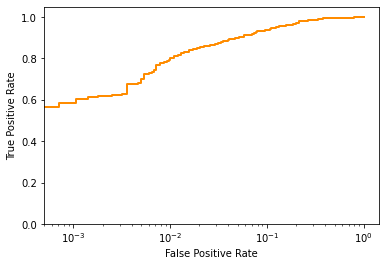

accuracy_threshold_values DONE


In [46]:
fpr, tpr, thresholds = accuracy_threshold_values(X_test, y_test, clf, log=True)

## Próg dla najlepszej dokładności z krzywej ROC

In [47]:
# https://albertusk95.github.io/posts/2019/12/best-threshold-maximize-accuracy-from-roc-pr-curve/
def best_threshold_from_roc_curve(tpr, fpr, thresholds, num_pos_class, num_neg_class):
    tp = tpr * num_pos_class
    tn = (1 - fpr) * num_neg_class
    acc = (tp + tn) / (num_pos_class + num_neg_class)

    best_threshold = thresholds[np.argmax(acc)]
    return best_threshold, np.max(acc), acc

In [48]:
num_pos_class = np.count_nonzero(y_test == 1)
num_neg_class = np.count_nonzero(y_test == -1)
best_accuracy_threshold, best_accuracy, acc = best_threshold_from_roc_curve(fpr, tpr, thresholds, num_pos_class, num_neg_class)
print(f'Maximal accuracy: {best_accuracy_threshold}, with {best_accuracy} accuracy.')

Maximal accuracy: 9.476249107982936, with 0.8565310492505354 accuracy.


In [49]:
num_pos_class/num_neg_class

0.1675

## Test klasyfikatora

In [50]:
import time

print("TRAIN ACC: " + str(clf.score(X_train, y_train)))
y_test_df = clf.decision_function(X_test)
y_test_pred = (y_test_df > 0) * 2 - 1
acc = np.sum(y_test == y_test_pred) / len(y_test)
print("TEST ACC: " + str(acc))
sens = np.sum(y_test[test_index_pos] == y_test_pred[test_index_pos]) / len(test_index_pos)
far = 1.0 - np.sum(y_test[test_index_neg] == y_test_pred[test_index_neg]) / len(test_index_neg)
print("TEST SENSITIVITY: " + str(sens))
print("TEST FAR: " + str(far))

TRAIN ACC: 0.9675518199778991
TEST ACC: 0.9602324869990823
TEST SENSITIVITY: 0.8592750533049041
TEST FAR: 0.02285714285714291


In [51]:
accuracies = []
sensitivities = []
fars = []
for t in thresholds:
    y_test_pred = (y_test_df > t) * 2 - 1
    accuracies.append(np.sum(y_test == y_test_pred) / len(y_test))
    sens = np.sum(y_test[test_index_pos] == y_test_pred[test_index_pos]) / len(test_index_pos)
    far = 1.0 - np.sum(y_test[test_index_neg] == y_test_pred[test_index_neg]) / len(test_index_neg)
    sensitivities.append(sens)
    fars.append(far)

Text(0, 0.5, 'Accuracy')

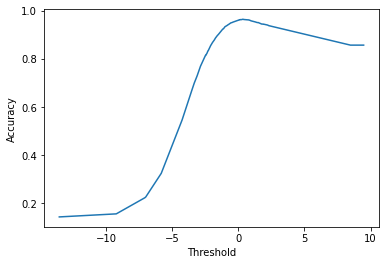

In [52]:
plt.plot(thresholds, accuracies)
plt.xlabel("Threshold")
plt.ylabel("Accuracy")

Text(0, 0.5, 'Sensitivity')

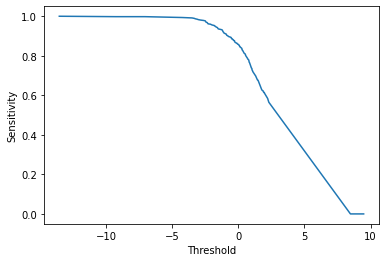

In [53]:
plt.plot(thresholds, sensitivities)
plt.xlabel("Threshold")
plt.ylabel("Sensitivity")

Text(0, 0.5, 'FAR')

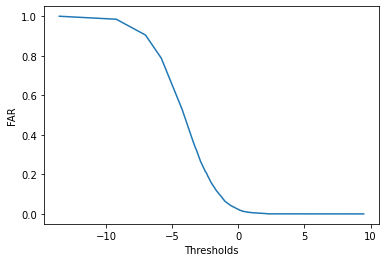

In [54]:
plt.plot(thresholds, fars)
plt.xlabel("Thresholds")
plt.ylabel("FAR")

In [55]:
np.max(accuracies), thresholds[np.argmax(accuracies)]

(0.9639033343530131, 0.3382131096963843)